In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("bfloat16 support:", torch.cuda.is_bf16_supported() if torch.cuda.is_available() else "N/A")


PyTorch version: 2.7.1+cu128
Device: cuda
bfloat16 support: True


In [3]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention mechanism implementation.
    
    Args:
        d_model (int): Dimension of the model/embedding
        num_heads (int): Number of attention heads
        dropout (float): Dropout probability
        dtype: Data type for the model (default: torch.bfloat16)
    """
    
    def __init__(self, d_model, num_heads, dropout=0.1, dtype=torch.bfloat16):
        super(MultiHeadAttention, self).__init__()
        
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension of each head
        self.dtype = dtype
        
        # Linear transformations for Q, K, V
        self.w_q = nn.Linear(d_model, d_model, dtype=dtype)
        self.w_k = nn.Linear(d_model, d_model, dtype=dtype)
        self.w_v = nn.Linear(d_model, d_model, dtype=dtype)
        
        # Output projection
        self.w_o = nn.Linear(d_model, d_model, dtype=dtype)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize weights using Xavier uniform initialization"""
        for module in [self.w_q, self.w_k, self.w_v, self.w_o]:
            nn.init.xavier_uniform_(module.weight)
            nn.init.zeros_(module.bias)
    
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Compute scaled dot-product attention.
        
        Args:
            Q, K, V: Query, Key, Value tensors of shape (batch_size, num_heads, seq_len, d_k)
            mask: Optional mask tensor
            
        Returns:
            attention_output: Weighted values
            attention_weights: Attention weights for visualization
        """
        batch_size, num_heads, seq_len, d_k = Q.size()
        
        # Compute attention scores (ensure proper scaling for bfloat16)
        scale = math.sqrt(d_k)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / scale
        
        # Apply mask if provided
        if mask is not None:
            # Expand mask to match the shape of scores
            mask = mask.unsqueeze(1).unsqueeze(1)  # (batch_size, 1, 1, seq_len)
            # Use a smaller negative value for bfloat16 to avoid overflow
            mask_value = -65504.0 if self.dtype == torch.bfloat16 else -1e9
            scores.masked_fill_(mask == 0, mask_value)
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention weights to values
        attention_output = torch.matmul(attention_weights, V)
        
        return attention_output, attention_weights
    
    def forward(self, query, key, value, mask=None):
        """
        Forward pass of multi-head attention.
        
        Args:
            query, key, value: Input tensors of shape (batch_size, seq_len, d_model)
            mask: Optional mask tensor of shape (batch_size, seq_len)
            
        Returns:
            output: Multi-head attention output
            attention_weights: Attention weights for all heads
        """
        batch_size, seq_len, d_model = query.size()
        
        # 1. Linear transformations and reshape for multi-head attention
        Q = self.w_q(query).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.w_k(key).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.w_v(value).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        # 2. Apply scaled dot-product attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        
        # 3. Concatenate heads and apply output projection
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, seq_len, d_model
        )
        
        output = self.w_o(attention_output)
        
        return output, attention_weights


In [5]:
# Setup profiling parameters
batch_size = 1024
d_model = 1024
head_dim = 16
num_heads = d_model // head_dim  # 64 heads
seq_len = 64
dtype = torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32

print(f"Configuration:")
print(f"Batch size: {batch_size}")
print(f"Embedding dimension: {d_model}")
print(f"Number of heads: {num_heads}")
print(f"Head dimension: {head_dim}")
print(f"Sequence length: {seq_len}")
print(f"Device: {device}")
print(f"Data type: {dtype}")

# Create model instances with bfloat16
model_baseline = MultiHeadAttention(d_model, num_heads, dropout=0.0, dtype=dtype).to(device)
model_compiled = MultiHeadAttention(d_model, num_heads, dropout=0.0, dtype=dtype).to(device)

# Load same weights for fair comparison
model_compiled.load_state_dict(model_baseline.state_dict())

# Compile the model with torch.compile (default settings)
model_compiled = torch.compile(model_compiled)

# Create sample input data with bfloat16
sample_input = torch.randn(batch_size, seq_len, d_model, device=device, dtype=dtype)

print(f"\nInput tensor shape: {sample_input.shape}")
print(f"Input tensor dtype: {sample_input.dtype}")
print(f"Memory usage: {sample_input.numel() * sample_input.element_size() / 1024**2:.2f} MB")


Configuration:
Batch size: 1024
Embedding dimension: 1024
Number of heads: 64
Head dimension: 16
Sequence length: 64
Device: cuda
Data type: torch.bfloat16

Input tensor shape: torch.Size([1024, 64, 1024])
Input tensor dtype: torch.bfloat16
Memory usage: 128.00 MB


In [6]:
import time

def benchmark_model(model, input_tensor, num_runs=100):
    """Benchmark model performance"""
    model.eval()
    times = []
    
    with torch.no_grad():
        for i in range(num_runs):
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            start = time.perf_counter()
            output, _ = model(input_tensor, input_tensor, input_tensor)
            
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            
            end = time.perf_counter()
            times.append((end - start) * 1000)  # Convert to milliseconds
    
    return times


In [7]:
# Profile baseline model
print("Profiling baseline model...")
print(f"Model dtype: {next(model_baseline.parameters()).dtype}")

# Warm up
print("Warming up baseline model...")
with torch.no_grad():
    for _ in range(10):
        _ = model_baseline(sample_input, sample_input, sample_input)
torch.cuda.synchronize() if torch.cuda.is_available() else None

# Benchmark
baseline_times = benchmark_model(model_baseline, sample_input, num_runs=100)

print(f"Baseline model performance:")
print(f"  Median: {np.median(baseline_times):.2f} ms")
print(f"  Mean:   {np.mean(baseline_times):.2f} ms")
print(f"  Std:    {np.std(baseline_times):.2f} ms")
print(f"  Min:    {np.min(baseline_times):.2f} ms")
print(f"  Max:    {np.max(baseline_times):.2f} ms")


Profiling baseline model...
Model dtype: torch.bfloat16
Warming up baseline model...


Baseline model performance:
  Median: 5.85 ms
  Mean:   5.85 ms
  Std:    0.02 ms
  Min:    5.84 ms
  Max:    6.03 ms


In [8]:
# Profile torch.compile model
print("Profiling torch.compile model...")
print(f"Compiled model dtype: {next(model_compiled.parameters()).dtype}")

# Warm up (important for compiled model to trigger compilation)
print("Warming up compiled model (this may take a moment for first compilation)...")
with torch.no_grad():
    for _ in range(10):
        _ = model_compiled(sample_input, sample_input, sample_input)
torch.cuda.synchronize() if torch.cuda.is_available() else None

# Benchmark
compiled_times = benchmark_model(model_compiled, sample_input, num_runs=100)

print(f"torch.compile model performance:")
print(f"  Median: {np.median(compiled_times):.2f} ms")
print(f"  Mean:   {np.mean(compiled_times):.2f} ms")
print(f"  Std:    {np.std(compiled_times):.2f} ms")
print(f"  Min:    {np.min(compiled_times):.2f} ms")
print(f"  Max:    {np.max(compiled_times):.2f} ms")

# Calculate speedup
speedup = np.median(baseline_times) / np.median(compiled_times)
print(f"\nSpeedup with torch.compile: {speedup:.2f}x")


Profiling torch.compile model...
Compiled model dtype: torch.bfloat16
Warming up compiled model (this may take a moment for first compilation)...


torch.compile model performance:
  Median: 5.06 ms
  Mean:   6.18 ms
  Std:    11.21 ms
  Min:    5.04 ms
  Max:    117.73 ms

Speedup with torch.compile: 1.16x


In [9]:

import torch_tensorrt
print("torch_tensorrt imported successfully")

# Create TensorRT optimized model
print("Creating TensorRT optimized model...")
model_tensorrt = MultiHeadAttention(d_model, num_heads, dropout=0.0, dtype=dtype).to(device)
model_tensorrt.load_state_dict(model_baseline.state_dict())
model_tensorrt.eval()

print("Attempting TensorRT compilation with bfloat16...")
with torch.no_grad():
    model_tensorrt = torch_tensorrt.compile(
        model_tensorrt,
        inputs=[
            torch_tensorrt.Input(shape=[batch_size, seq_len, d_model], dtype=torch.bfloat16),
            torch_tensorrt.Input(shape=[batch_size, seq_len, d_model], dtype=torch.bfloat16),
            torch_tensorrt.Input(shape=[batch_size, seq_len, d_model], dtype=torch.bfloat16)
        ],
        enabled_precisions={torch.bfloat16, torch.float16}
    )
print("TensorRT optimization with bfloat16 completed!")


<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cuda module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.driver module instead.
<frozen importlib._bootstrap_external>:1241: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.
2025-06-29 17:11:35,021 - INFO - flashinfer.jit: Prebuilt kernels not found, using JIT backend


[TensorRT-LLM] TensorRT-LLM version: 1.0.0rc1


/root/python_env/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


[06/29/2025-17:11:35] [TRT] [W] Functionality provided through tensorrt.plugin module is experimental.
torch_tensorrt imported successfully
Creating TensorRT optimized model...
Attempting TensorRT compilation with bfloat16...


  return torch.tensor(tensor).dtype



TensorRT optimization with bfloat16 completed!


In [10]:

print("Profiling TensorRT model...")
tensorrt_input = sample_input

# Warm up
print("Warming up TensorRT model...")
with torch.no_grad():
    for _ in range(10):
        _ = model_tensorrt(tensorrt_input, tensorrt_input, tensorrt_input)
torch.cuda.synchronize() if torch.cuda.is_available() else None

# Benchmark
tensorrt_times = benchmark_model(model_tensorrt, tensorrt_input, num_runs=100)

print(f"TensorRT model performance:")
print(f"  Median: {np.median(tensorrt_times):.2f} ms")
print(f"  Mean:   {np.mean(tensorrt_times):.2f} ms")
print(f"  Std:    {np.std(tensorrt_times):.2f} ms")
print(f"  Min:    {np.min(tensorrt_times):.2f} ms")
print(f"  Max:    {np.max(tensorrt_times):.2f} ms")

# Calculate speedup vs baseline
tensorrt_speedup = np.median(baseline_times) / np.median(tensorrt_times)
print(f"\nSpeedup with TensorRT: {tensorrt_speedup:.2f}x")


Profiling TensorRT model...
Warming up TensorRT model...


TensorRT model performance:
  Median: 6.17 ms
  Mean:   6.17 ms
  Std:    0.01 ms
  Min:    6.15 ms
  Max:    6.21 ms

Speedup with TensorRT: 0.95x


PERFORMANCE SUMMARY
Model           Median (ms)   Std (ms)     Speedup   
----------------------------------------------------
Baseline        5.85          0.02         1.00      x
torch.compile   5.06          11.21        1.16      x
TensorRT        6.17          0.01         0.95      x


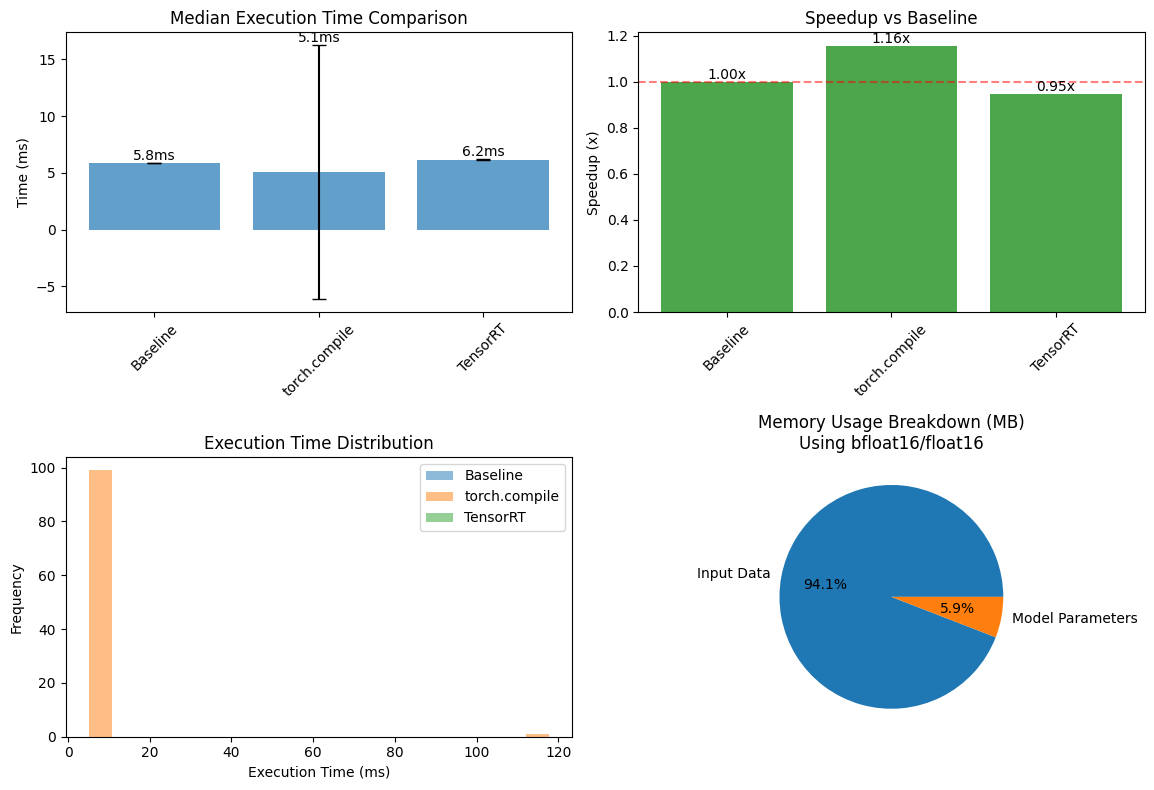


Model Statistics:
Total Parameters: 4,198,400
Parameter dtype: torch.bfloat16
Bytes per parameter: 2
Model Memory: 8.01 MB
Input Memory per batch: 128.00 MB
Memory savings vs float32: 8.01 MB


In [11]:
# Performance Comparison and Visualization
print("=" * 60)
print("PERFORMANCE SUMMARY")
print("=" * 60)

# Prepare data for visualization
models = ['Baseline']
median_times = [np.median(baseline_times)]
std_times = [np.std(baseline_times)]

models.append('torch.compile')
median_times.append(np.median(compiled_times))
std_times.append(np.std(compiled_times))

if tensorrt_times is not None:
    models.append('TensorRT')
    median_times.append(np.median(tensorrt_times))
    std_times.append(np.std(tensorrt_times))

# Create comparison table
print(f"{'Model':<15} {'Median (ms)':<13} {'Std (ms)':<12} {'Speedup':<10}")
print("-" * 52)
for i, model in enumerate(models):
    speedup = median_times[0] / median_times[i] if median_times[i] > 0 else 0
    print(f"{model:<15} {median_times[i]:<13.2f} {std_times[i]:<12.2f} {speedup:<10.2f}x")

# Create visualization
plt.figure(figsize=(12, 8))

# Bar plot with error bars
plt.subplot(2, 2, 1)
bars = plt.bar(models, median_times, yerr=std_times, capsize=5, alpha=0.7)
plt.title('Median Execution Time Comparison')
plt.ylabel('Time (ms)')
plt.xticks(rotation=45)
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + std_times[i],
             f'{height:.1f}ms', ha='center', va='bottom')

# Speedup comparison
if len(models) > 1:
    plt.subplot(2, 2, 2)
    speedups = [median_times[0] / t for t in median_times]
    bars = plt.bar(models, speedups, alpha=0.7, color='green')
    plt.title('Speedup vs Baseline')
    plt.ylabel('Speedup (x)')
    plt.xticks(rotation=45)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}x', ha='center', va='bottom')

# Distribution plots
plt.subplot(2, 2, 3)
plt.hist(baseline_times, alpha=0.5, label='Baseline', bins=20)
plt.hist(compiled_times, alpha=0.5, label='torch.compile', bins=20)
if tensorrt_times is not None:
    plt.hist(tensorrt_times, alpha=0.5, label='TensorRT', bins=20)
plt.xlabel('Execution Time (ms)')
plt.ylabel('Frequency')
plt.title('Execution Time Distribution')
plt.legend()

# Memory usage estimation
plt.subplot(2, 2, 4)
total_params = sum(p.numel() for p in model_baseline.parameters())
memory_per_batch = sample_input.numel() * sample_input.element_size() / 1024**2

# Calculate model memory based on actual dtype
param_dtype = next(model_baseline.parameters()).dtype
if param_dtype == torch.bfloat16 or param_dtype == torch.float16:
    bytes_per_param = 2  # 16-bit
    dtype_name = "bfloat16/float16"
elif param_dtype == torch.float32:
    bytes_per_param = 4  # 32-bit  
    dtype_name = "float32"
else:
    bytes_per_param = 4  # fallback
    dtype_name = str(param_dtype)

model_memory = total_params * bytes_per_param / 1024**2

categories = ['Input Data', 'Model Parameters']
sizes = [memory_per_batch, model_memory]
plt.pie(sizes, labels=categories, autopct='%1.1f%%')
plt.title(f'Memory Usage Breakdown (MB)\nUsing {dtype_name}')

plt.tight_layout()
plt.show()

print(f"\nModel Statistics:")
print(f"Total Parameters: {total_params:,}")
print(f"Parameter dtype: {param_dtype}")
print(f"Bytes per parameter: {bytes_per_param}")
print(f"Model Memory: {model_memory:.2f} MB")
print(f"Input Memory per batch: {memory_per_batch:.2f} MB")
print(f"Memory savings vs float32: {((total_params * 4) - (total_params * bytes_per_param)) / 1024**2:.2f} MB")
